My last post was an initial attempt at testing whether I could successfully predict experimental condition (a classifier with four classes) based on two of my most important quantitative variables: onset to speak duration and object word duration. The results, below, were fairly middling:

Which shouldn't be surprising, actually, given how densely-packed the data points are, and how they don't seem to fit a nicely-divided linear pattern. The kernel I used in the previous post was a simple linear one, which means that it was only capable of drawing straight lines (hyperplanes). The problem there isn't that the categories overlap a bit, but rather that the category boundaries aren't linear. I need an approach that won't assume linear boundaries. Enter linear, and then quadratic, discriminant analysis.

I'm using a couple of new packages today, ones that allow for cross-validation and some quality-of-life improvements when it comes to getting errant columns in line with data format expectations.

In [1]:
from dissdata import importation
from sklearn import cross_validation, preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# This gets ahold of the data through a custom importation class I wrote
exp = importation()

feat_col = exp.exp[1][['onset_dur','object_dur']]
# This nifty function from scikit's preprocessing normalizes all of the columns
X = preprocessing.StandardScaler().fit_transform(feat_col)
# Then this guy converts a column of string-type categories (identical, control,
# related, unrelated) into a more-usable set of categorical integers.
labeler = preprocessing.LabelEncoder().fit(exp.exp[1]['condition'])
y = labeler.transform(exp.exp[1]['condition'])

The next bit creates training and testing sets, which are important for assessing overfitting (and which I didn't use at all last time, because the post had already gotten too long). This takes 35% of the data in X and y and makes them training data, and the rest test data. The random state ensures the possibility of duplication.

In [2]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = .35, random_state = 1)

We have training and testing data, so let's construct some models. The below is actually fairly similar in principle to the Linear SVC (and isn't what we'll be sticking with) - it wants to correctly predict category membership for new data points. [N.B.: I actually looked a bit into the difference between LDA and Linear SVC, and couldn't find an answer I considered satisfactory. If you know of one, please let me know!] The discriminant, as near as I can tell, wants to maximize the distance between the two categories, or rather, find a hyperplane that maximally separates them. From a theoretical perspective, this is a little complicated. Luckily, from a programming perspective, it's quite straightforward.

We create a linear discriminant model, and then have some options for what to do. One is to fit the model to some data, which sets the parameters. We can then make predictions about category membership, either from training or testing data, and see how those measure up against the real thing. I'm lucky enough to have knowledge of the categories (i.e. this is a supervised learning problem). Then, we can calculate how well the model did in predicting category membership. Let's do some of that.

In [3]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(X_train,y_train)
lda.predict(X_test)
lda.score(X_test,y_test)

0.41966173361522197

This is pretty miserable success, actually. If I were choosing completely randomly, I would guess correctly about 25% of the time. That means this model only does about 7% better (or, depending on your perspective, about 25% (.25 * 1.25 = .312)), which isn't even good enough for government work. But, perhaps this fit is proprietary (which it is by definition) and doesn't actually represent the data well compared to another model. Let's fit several such models (using different training data) and see how well we can do averaged over many attempts.

The below runs 10 different iterations of splitting up the data, testing on 20% of it.

In [4]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(X_train,y_train)
cvthing = cross_validation.ShuffleSplit(y.shape[0], n_iter = 10, test_size = .2)
scores = cross_validation.cross_val_score(lda,X,y,cv = cvthing)
scores.mean()

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


0.39963031423290207

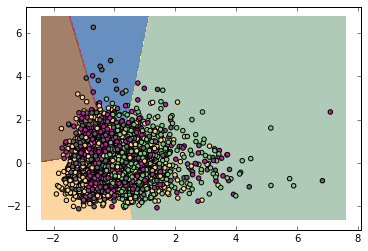

In [6]:
# This defines a range for the plot - slightly bigger than the highest
# and lowest values present in the data.
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# This function is ridiculous. It produces two square matrices of the same
# dimensionality, namely as many steps as there are between the min
# and max values (in this case 100x100). This lets you cover the range of
# values in each of the matrices and pair up appropriate x and y coordinates.
# Here, it's going to get used to generate an appropriately-sized plot,
# including the predictions made by the SVC at each combination of points
# along the dimensions.
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

# The prediction is obvious. np.c_ and .ravel() perform transformations
# that make it possible to feed the appropriate matrices into the predict
# function and produce the correctly-dimensioned Z matrix. Ravel spits
# out a 1-d object, and then c_ stacks the two of those objects column-wise
# so that predict gets the correct input.
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])

# And then we want to make sure that the Z matrix is in the correct shape
# so that it corresponds with the x and y coordinates that we're plotting
Z = Z.reshape(xx.shape)

# Finally, we plot the predicted values for the dense coordinate map we
# generated (top plotting function), and then overlay the actual categories
# (bottom plotting function)
plt.contourf(xx, yy, Z, cmap=plt.cm.Accent, alpha=0.8)
plt.scatter(X[:,0],X[:,1], c = y, cmap = plt.cm.Accent)

The situation is actually worse than it looked. Cross-validation shows that on average, a model of this sort does very poorly at classifying these data - no better than chance in most cases. Once again, this may be down to the wrong choice of kernel, which I will explore in the next post (honest!).
